## Object detection and semantic segmentation ##

Models included in pytorch (https://pytorch.org/vision/stable/_modules/torchvision/models/segmentation/segmentation.html)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval() ## We load a segmentation model from pytorch

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\david/.cache\torch\hub\checkpoints\fcn_resnet101_coco-7ecb50ca.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

## Lets go step by step ##

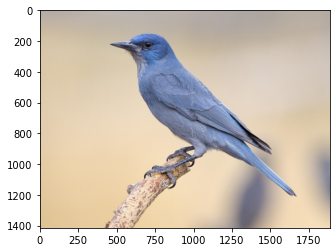

In [2]:
# Open and show the img
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


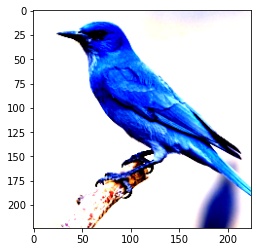

torch.Size([1, 3, 224, 224])


In [3]:
# Apply the needed transformations

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])]) #Imagenet specific
inp = trf(img).unsqueeze(0)
plt.imshow(inp.squeeze().permute(1,2,0)); plt.show()
print(inp.shape)

In [4]:
# Pass the input through the net and get the segmentation output (same size tensor but with the 21 labels instead of channels)
out = fcn(inp)['out']
print (out.shape) # [batch_size, label_size, w, h]

torch.Size([1, 21, 224, 224])


In [5]:
# With squeeze we get rid of the 1 dimension. Argmax applied on dim=0 (after squeeze) allows us to keep max_index per pixel position
labeled_img = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (labeled_img.shape)
print (np.unique(labeled_img))

(224, 224)
[0 3]


In [18]:
# Helper function to decode the image with labels
def decode_segmap(image, nc=21):
      
    ## The model is trained on the COCO dataset, and can predict these 21 classes. Try changing colors if you want!
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l # Create a boolean array (same size) with true where image indx is same as l
        
        # fill when True
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    # Create a 3d array with rgb (w, h, channels)
    rgb = np.stack([r, g, b], axis=2)
    return rgb

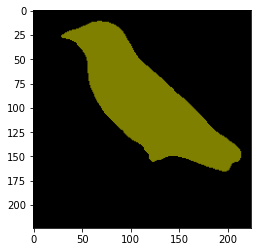

In [7]:
rgb = decode_segmap(labeled_img)
plt.imshow(rgb); plt.show()

In [8]:
## Putting it all together!

def segment(net, path):
    img = Image.open(path)
    # Show original img
    plt.imshow(img); plt.axis('off'); plt.show()
    
    trf = T.Compose([T.Resize(256), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    print (np.unique(om))
    rgb = decode_segmap(om)
    
    # Show labeled img
    plt.imshow(rgb); plt.axis('off'); plt.show()
      
    labeled = Image.fromarray(rgb).convert('RGBA') #To blend we need the Alpha channel
    src_img = img
    src_img = src_img.resize(labeled.size)
    alphaBlended1 = Image.blend(src_img.convert("RGBA"), labeled, alpha=.5)
    
    plt.imshow(alphaBlended1); plt.axis('off'); plt.show()
    
    

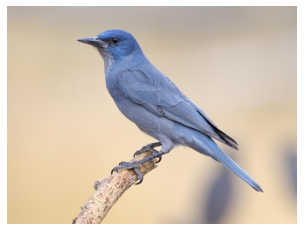

[0 3]


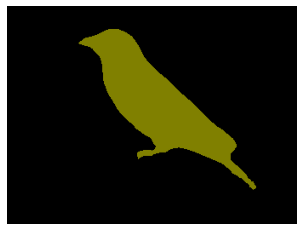

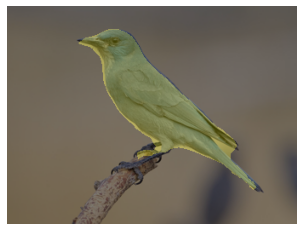

In [9]:
segment(fcn, './bird.png')

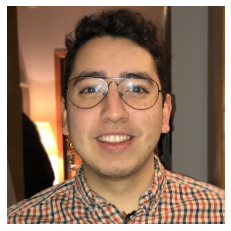

[ 0 15]


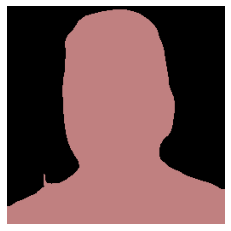

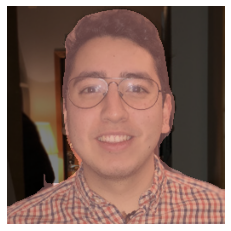

In [10]:
segment(fcn, './ai5982.jpg')

## Lets try multiple objects ##

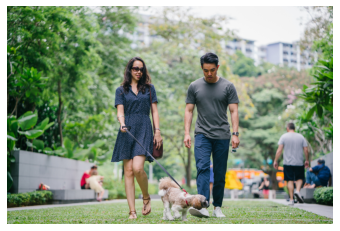

[ 0 12 15]


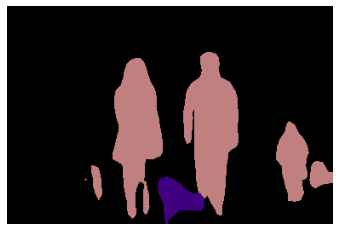

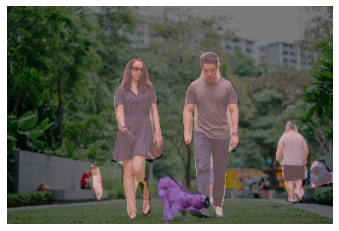

In [11]:
img = Image.open('./dog-park.png')
segment(fcn, path='./dog-park.png')

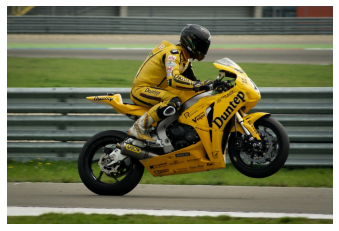

[ 0 14 15]


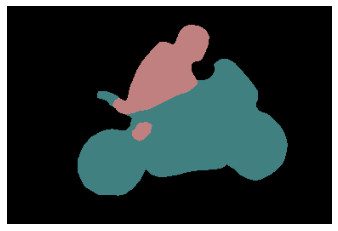

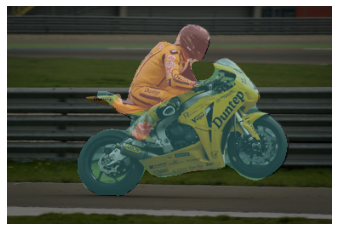

In [12]:
segment(fcn, './person-bike.jpg')

### As an exercise, using PIL Image or OpenCV, try to mask the image (cut out the people) ###

## Assignment Advanced 1.1

Use Mask R-CNN (or other type of network) to do instance segmentation, i used a modified version of this:https://learnopencv.com/mask-r-cnn-instance-segmentation-with-pytorch/ to understand how to make the different segmentation solution with a pretrained mask-rcnn network

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np
import random
import cv2

def segment_maskRCNN(model, path):
    threshold = 0.5
    img = Image.open(path)
    plt.imshow(img); plt.axis('off'); plt.show()
    

    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    
    pred_class = [i for i in list(pred[0]['labels'].numpy())]
    
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = color_masks(masks[i], i)
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        plt.figure(figsize=(10,20))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()



#makes new colours for eash instance (obs only 10 of them)
def color_masks(image, i):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[i]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask
    


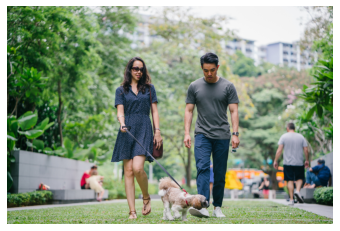

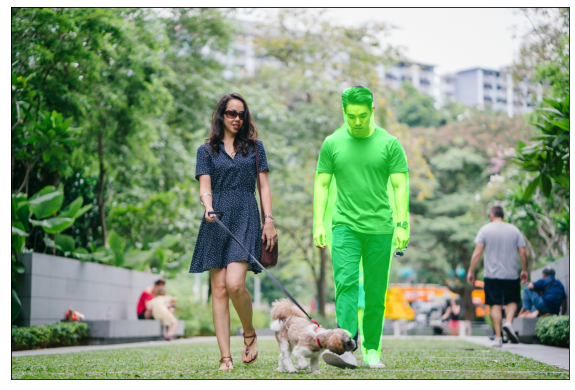

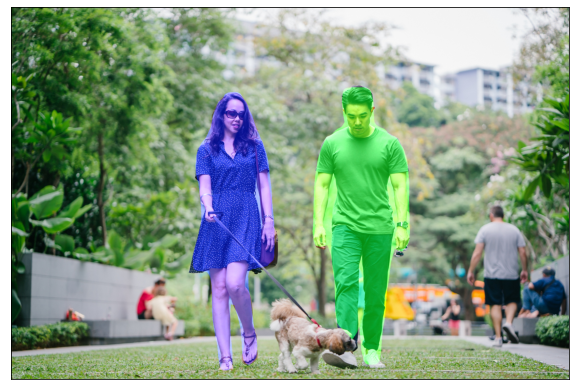

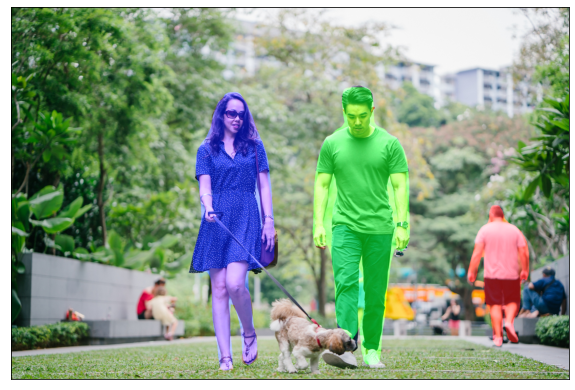

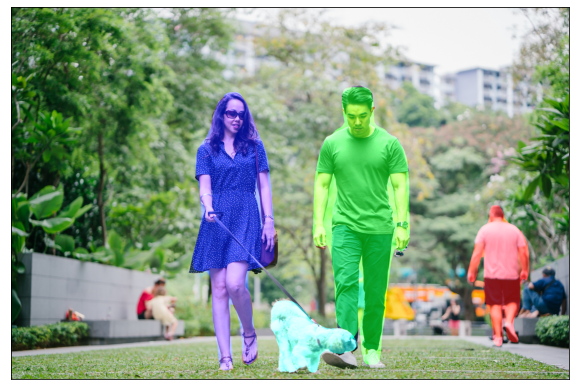

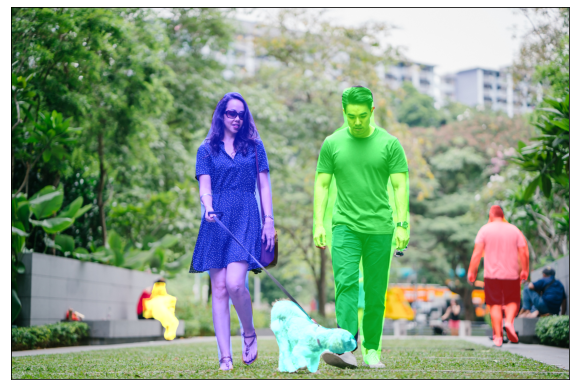

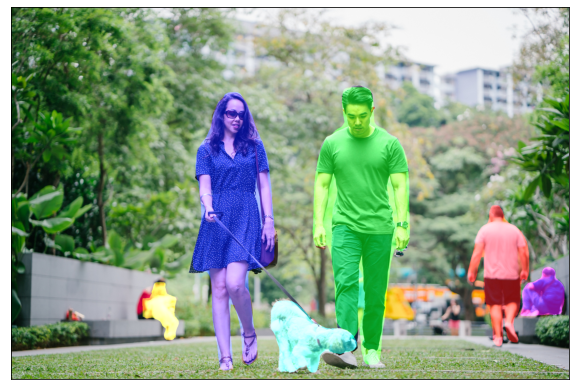

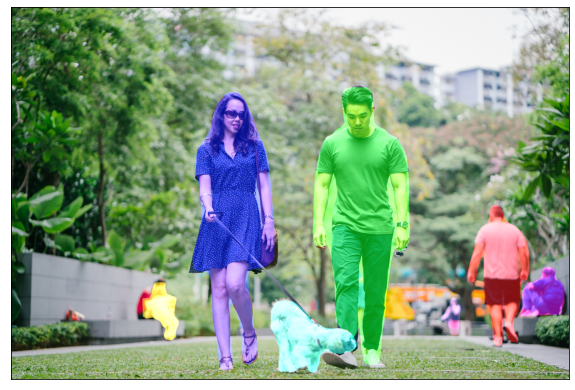

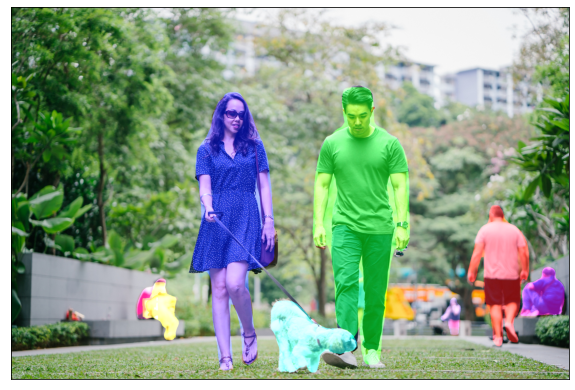

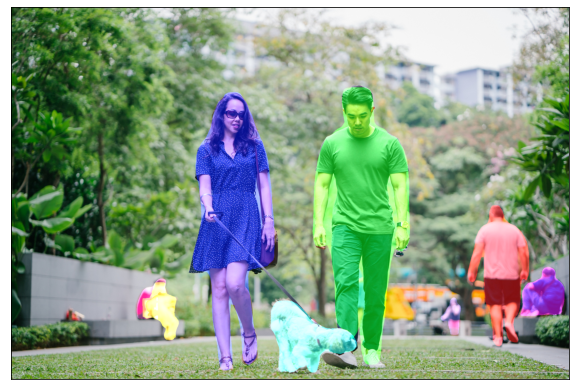

done


In [25]:
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

img = Image.open('./dog-park.png')
segment_maskRCNN(model, path='./dog-park.png')

print('done')

# Asignment 1 advanced 1.2.1

Apply occlusion to gather heatmap, i have learned from https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e to implement this assignment, this is probably the same as you used on ''visualizing-filters'' so I thought it probably does it well.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

model = models.vgg16(pretrained=True)
def image_print(path):
    img = Image.open(path)
    plt.imshow(img); plt.axis('off'); plt.show()
    return img
print('done')

done


In [6]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
  
    width, height = image.shape[-2], image.shape[-1]
  
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    heatmap = torch.zeros((output_height, output_width))
    
    for h in range(0, height):
        for w in range(0, width):
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            if (w_end) >= width or (h_end) >= height:
                continue
            input_image = image.clone().detach()
            
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            heatmap[h, w] = prob 

    return heatmap
print('done')

done


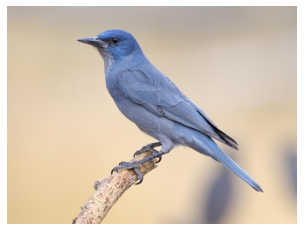

done


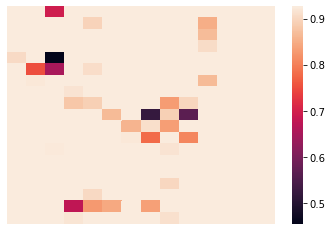

In [9]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
img = transform(image_print('./bird.png'))
input_img = img.unsqueeze(0)
out = model(input_img)
_, pred = torch.max(out.data,1)

out = nn.functional.softmax(out, dim = 1)
prob_no_occ, _ = torch.max(out.data, 1)
prob_no_occ = prob_no_occ[0].item()

heatmap = occlusion(model, input_img, pred[0].item(), 32, 14)

imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()

print('done')

In [73]:
print(pred[0].item())# 17 is "jay" a type of bird which are often times blue

17
